In [10]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from collections import Counter

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler 

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy import sparse

from datetime import date, datetime

In [3]:
# functions required to perform basic transformations
# these transformations can be safely applied to all the data set (inc validation)
# because they only take into consideration the values of the current row

# function to translate gender into 
def get_gender(_input):
    if 'Female' in _input:
        return 'F'
    elif 'Male' in _input:
        return 'M'
    else:
        return 'U'

# function that returns 1 if animal was operated; 0 otherwise
def is_operated(_input):    
    return int(_input.split()[0] in ['Neutered', 'Spayed'])   

# function that normalises age of animal in years
def get_age_in_years(_input):
    age = 0.0
    age_list = _input.split()
    if "year" in age_list[1]:
        age = float(age_list[0])
    elif "month" in age_list[1]:
        age = float(age_list[0]) / 12.0
    elif "week" in age_list[1]:
        age = float(age_list[0]) / 52.0
    else:
        # if less than 1 week, default to 1 week
        age = 1.0 / 52.0
    return round(age, 3)

# Transform ages to categoris as follows:
# 1 = neonatal; 2 = infant; 3 = child; 4 = adolescent; 5 = young_adult; 6 = mature_adult; 7 = old
# These categories are based on rate that animal ages w.r.t. human years and the stages of human development
# https://www.ajdesigner.com/fl_cat_age/cat_age.php; https://pets.webmd.com/dogs/how-to-calculate-your-dogs-age
def get_age_in_labels(_input):
    age_label = 0
    age_list = _input.split()
    age = int(age_list[0])
    if "year" in age_list[1]:
        # 
        options = [4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7]
        age = age - 1 if age < 11 else 10
        age_label = options[age]        
    elif "month" in age_list[1]:
        options = [2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
        age_label = options[age-1]
    elif "week" in age_list[1]:        
        age_label = 1
    else:
        # if less than 1 week, default to 1 week
        age_label = 1
    return age_label

# this function returns purity category: "pure", "mixed", "cross"
# depending on whether breed string features just the animal breed, the word "mix" or a fwd-slash
def get_breed_purity(_input):
    breed_purity = ""
    if "/" in _input:
        breed_purity = "cross"
    elif "Mix" in _input:
        breed_purity = "mix"
    else:
        breed_purity = "pure"
    return breed_purity

# code to determine season from: https://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [4]:
# import training data in pandas dataframe df
df = pd.read_csv('train.csv', header=0, sep=",")
# print columns having at least one null entry
#print df.isnull().any()
# only 1 case of unknown sex
df[df["SexuponOutcome"].isnull() == True]
# only 18 cases of unknown age
len(df[df["AgeuponOutcome"].isnull() == True])
# remove null cases 

# remove null ages
df = df[~df['AgeuponOutcome'].isnull()]
df = df[~df['SexuponOutcome'].isnull()]
#print df.isnull().any()

# there are 22 cases where Age is 0 years; the distribution of outcomes (compared to the cases where age is known)
# strongly suggests that these animals are neonatal.  Defaulting the value to 1 week
print df[(df.AgeuponOutcome == '0 years')]["OutcomeType"].value_counts()
df.loc[df.AgeuponOutcome == '0 years', 'AgeuponOutcome'] = "1 week"


Transfer      19
Euthanasia     2
Died           1
Name: OutcomeType, dtype: int64


In [5]:
# we are going to perform dummy converstion, label encoding prior to splitting
# replace missing value with "Unknown"

df["HasName"] = (~df.loc[:,"Name"].isnull()).apply(lambda x: int(x))
df["IsOperated"] = df["SexuponOutcome"].apply(is_operated)
df["Gender"] = df["SexuponOutcome"].apply(get_gender)
df["AgeCategory"] = df["AgeuponOutcome"].apply(get_age_in_labels)
df["BreedPurity"] = df["Breed"].apply(get_breed_purity).astype('category')
df["IsWeekend"] = pd.to_datetime(df.DateTime).apply(lambda x: int(1  if x.weekday() in [5,6] else 0))
df["Season"] = pd.to_datetime(df.DateTime).apply(get_season)
#df = df.assign(AgeCategory = scale(df.AgeuponOutcome.apply(get_age_in_years)))#.drop(["AgeuponOutcome"], axis=1)

#df["Month"] = pd.to_datetime(df.DateTime).apply(lambda x: x.strftime("%b"))
df = pd.get_dummies(df, columns=['AnimalType', 'Gender', 'BreedPurity', 'Season','AgeCategory'], drop_first=True)
#df = pd.get_dummies(df, columns=['AnimalType', 'Gender', 'BreedPurity', 'Season'], drop_first=True)
#df = pd.get_dummies(df, columns=['OutcomeType'])

# features that will be used to build our model
# HasName, AnimalType_Dog, Gender, is_operated, 
# lets start with a simple model that ignores the breed and color
# we will then build a more complex model that features TFID terms 

In [38]:
# Display columns to make selection easier
ids = range(len(df.columns))
[(x, df.columns[x]) for x in ids]

[(0, 'AnimalID'),
 (1, 'Name'),
 (2, 'DateTime'),
 (3, 'OutcomeType'),
 (4, 'OutcomeSubtype'),
 (5, 'SexuponOutcome'),
 (6, 'AgeuponOutcome'),
 (7, 'Breed'),
 (8, 'Color'),
 (9, 'HasName'),
 (10, 'IsOperated'),
 (11, 'IsWeekend'),
 (12, 'AnimalType_Dog'),
 (13, 'Gender_M'),
 (14, 'Gender_U'),
 (15, 'BreedPurity_mix'),
 (16, 'BreedPurity_pure'),
 (17, 'Season_spring'),
 (18, 'Season_summer'),
 (19, 'Season_winter'),
 (20, 'AgeCategory_2'),
 (21, 'AgeCategory_3'),
 (22, 'AgeCategory_4'),
 (23, 'AgeCategory_5'),
 (24, 'AgeCategory_6'),
 (25, 'AgeCategory_7')]

In [6]:
# retain model column names
model_columns = df.iloc[:,9:26].columns.values

# if age category is continuous
#model_columns = df.iloc[:,9:21].columns.values

#model_columns = df.iloc[:,[9,10,11,12,13]].columns.values
model_columns
#df.loc[:,"AgeCategory"]


array(['HasName', 'IsOperated', 'IsWeekend', 'AnimalType_Dog', 'Gender_M',
       'Gender_U', 'BreedPurity_mix', 'BreedPurity_pure', 'Season_spring',
       'Season_summer', 'Season_winter', 'AgeCategory_2', 'AgeCategory_3',
       'AgeCategory_4', 'AgeCategory_5', 'AgeCategory_6', 'AgeCategory_7'], dtype=object)

In [ ]:
# create feature and label array (when not using tfidx features)
X = df.loc[:, model_columns].values

#X = StandardScaler(with_mean=False).fit_transform(X)
y = df.iloc[:, 3].values
# uncomment the below to train ensemble of 1vsrest Logistic Classifiers
#y = df.iloc[:, 20:].values

# convert target variable to number
le = LabelEncoder()
y = le.fit_transform(y)
# we can compute inverse_transform to get back the labels
# le.inverse_transform(y)

# split in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
from sklearn.decomposition import TruncatedSVD
# was max_df 0.1
# now let's create the tfidf features
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2)
tfv = TfidfVectorizer(min_df=0.0025, max_df=0.5, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                     ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

breed_colour = list(df_train.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
breed_colour = tfv.fit_transform(breed_colour)

breed_colour.shape

def get_top_n_features(tfidf_array):
    weights = tfidf_array.mean(axis=0).ravel().tolist()
    weights_df = pd.DataFrame({'term': tfv.get_feature_names(), 'weight':weights})
    print weights_df.sort_values(by='weight', ascending=False).head(20)    

#weights = np.asarray(breed_colour.mean(axis=0)).ravel().tolist()
#weights_df = pd.DataFrame({'term': tfv.get_feature_names(), 'weight':weights})
#print weights_df.sort_values(by='weight', ascending=False).head(20)

# perform dimensionality reduction using SVD
#svd = TruncatedSVD(n_components=100)
#breed_colour_svd = svd.fit_transform(breed_colour)

X_train = df_train.loc[:, model_columns].values
#X_train = sparse.hstack((X_train, breed_colour))
X_train = np.hstack((X_train, breed_colour.toarray()))

#X_train = np.hstack((X_train, breed_colour_svd))
##ss = StandardScaler(with_mean=False)
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)

X_test = df_test.loc[:, model_columns].values
breed_colour_test = list(df_test.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
breed_colour_test = tfv.transform(breed_colour_test)
#breed_colour_test_svd = svd.transform(breed_colour_test)
X_test = np.hstack((X_test, breed_colour_test.toarray()))
#X_test = sparse.hstack((X_test, breed_colour_test))
#X_test = np.hstack((X_test, breed_colour_test_svd))
#X_test = ss.transform(X_test)

y_train = df_train.iloc[:, 3].values
y_test = df_test.iloc[:, 3].values

# convert target variable to number
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


arrays = [X_train, X_test, y_train, y_test]
print [x.shape for x in arrays]

In [ ]:
extended_model_columns = np.hstack((model_columns, tfv.get_feature_names()) )

In [ ]:
# get top features associated with outcome
get_top_n_features((X_train[y_train==3])[:,17:])


In [ ]:
# Check label proportions
from collections import Counter
_foo = Counter(y_test), Counter(y_train)
print _foo
# confirm that propotion of test outcome is similar to population proportion
print [round(float(_foo[0][x]) / sum(_foo[0].values()),3)   for x in _foo[0]]

# confirm that propotion of train outcome is similar to population proportion
print [round(float(_foo[1][x]) / sum(_foo[1].values()),3)   for x in _foo[1]]

# Random Forest Classification

In [ ]:
forest = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced')
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
for f in range(X_train.shape[1]):
#for f in range(25):
    print "%2d) %-*s %f" % (f+1, 30, extended_model_columns[indices[f]], importances[indices[f]])
    
#prediction = forest.predict_proba(X_test)
prediction = forest.predict(X_test)
prediction_prob = forest.predict_proba(X_test)

print len(range(25))
print len(indices[0:25])
le.classes_

In [ ]:
#print(classification_report(y_test, prediction, target_names=le.classes_))

def plot_feature_importance(importances, indices, feature_count, extended_model_columns):
    plt.title('Feature Importance')    

    plt.bar(range(feature_count),importances[indices[0:feature_count]], color='lightblue', align='center')
    plt.xticks(range(feature_count), extended_model_columns[indices[0:feature_count]], rotation = 90)
    plt.xlim([-1, feature_count])
    plt.tight_layout()
    fig = plt.figure(figsize=(20, 10))
    plt.show()
    plt.close()



In [15]:
# plot confusion matrix from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#cnm = confusion_matrix(y_test, prediction)
#plt.figure()
#plot_confusion_matrix(cnm, classes=le.classes_, title='Confusion matrix, without normalization')

#plt.show()
#plt.close()



# Dogs vs Cats

In [ ]:
# Random Forest Classification based on dogs and cats separately
# create feature and label array (when not using tfidx features)
X_dog = df.loc[df.AnimalType_Dog == 0, model_columns].values

#X = StandardScaler(with_mean=False).fit_transform(X)
y_dog = df.loc[df.AnimalType_Dog == 0, "OutcomeType"].values
# uncomment the below to train ensemble of 1vsrest Logistic Classifiers
#y = df.iloc[:, 20:].values

# convert target variable to number
le = LabelEncoder()
y_dog = le.fit_transform(y_dog)
# we can compute inverse_transform to get back the labels
# le.inverse_transform(y)

# split in training and testing sets
X_dog_train, X_dog_test, y_dog_train, y_dog_test = train_test_split(X_dog, y_dog, test_size=0.2, random_state=2)

In [ ]:
#forest_of_dogs = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced')
forest_of_dogs = RandomForestClassifier(n_estimators=1000, random_state=0)
forest_of_dogs.fit(X_dog_train, y_dog_train)
#importances = forest.feature_importances_
#indices = np.argsort(importances)[::-1]

In [ ]:
# predict outcome based on test dogs
prediction_dog = forest_of_dogs.predict(X_dog_test)
prediction_dog_prob = forest_of_dogs.predict_proba(X_dog_test)
print(classification_report(y_dog_test, prediction_dog, target_names=le.classes_))

In [ ]:
# was max_df 0.1
# now let's create the tfidf features
df_dog_train, df_dog_test = train_test_split(df[df.AnimalType_Dog == 0], test_size=0.2, random_state=2)

#tfv = TfidfVectorizer(min_df=0.0025, max_df=0.5, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
 #                    ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

    
breed_colour = list(df_dog_train.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
breed_colour = tfv.fit_transform(breed_colour)

breed_colour.shape

def get_top_n_features(tfidf_array):
    weights = tfidf_array.mean(axis=0).ravel().tolist()
    weights_df = pd.DataFrame({'term': tfv.get_feature_names(), 'weight':weights})
    print weights_df.sort_values(by='weight', ascending=False).head(20)    

# perform dimensionality reduction using SVD
#svd = TruncatedSVD(n_components=100)
#breed_colour_svd = svd.fit_transform(breed_colour)

X_dog_train = df_dog_train.loc[:, model_columns].values
#X_train = sparse.hstack((X_train, breed_colour))
X_dog_train = np.hstack((X_dog_train, breed_colour.toarray()))

X_dog_test = df_dog_test.loc[:, model_columns].values
breed_colour_test = list(df_dog_test.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
breed_colour_test = tfv.transform(breed_colour_test)
#breed_colour_test_svd = svd.transform(breed_colour_test)
X_dog_test = np.hstack((X_dog_test, breed_colour_test.toarray()))
#X_test = sparse.hstack((X_test, breed_colour_test))
#X_test = np.hstack((X_test, breed_colour_test_svd))
#X_test = ss.transform(X_test)

y_dog_train = df_dog_train.iloc[:, 3].values
y_dog_test = df_dog_test.iloc[:, 3].values

# convert target variable to number
le = LabelEncoder()
y_dog_train = le.fit_transform(y_dog_train)
y_dog_test = le.fit_transform(y_dog_test)


arrays = [X_dog_train, X_dog_test, y_dog_train, y_dog_test]
print [x.shape for x in arrays]

In [8]:
def create_vectoriser():
    tfd = TfidfVectorizer(min_df=0.0025, max_df=0.5, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                     ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
    return tfd

def get_features(df):
    text_features = list(df.apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
    return text_features

# Create SVD for cat/dog textual features separately

In [11]:
# Reduce breed/colour dimensionality using SVD, retain 10 components only
# Since breed/colour for dogs are markedly different than from cats, we create two vectorisers and SVD transformers
# The dog and cat components are reduced separately and then re-composed back to one training set.
from sklearn.decomposition import TruncatedSVD

df_train, df_test = train_test_split(df, test_size=0.2, random_state=2)

#tfv_d = TfidfVectorizer(min_df=0.0025, max_df=0.5, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
#                     ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

#tfv_c = TfidfVectorizer(min_df=0.0025, max_df=0.5, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
 #                    ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

tfv_d = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

tfv_c = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1,2), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

    
#dog_text_features = list(df_train[df_train.AnimalType_Dog==1].apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
dog_text_features = get_features(df_train[df_train.AnimalType_Dog==1])
dog_text_features = tfv_d.fit_transform(dog_text_features)
#cat_text_features = list(df_train[df_train.AnimalType_Dog==0] .apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
cat_text_features = get_features(df_train[df_train.AnimalType_Dog==0])
cat_text_features = tfv_c.fit_transform(cat_text_features)

dog_svd = TruncatedSVD(10)
cat_svd = TruncatedSVD(10)

dog_tfdid_svd = dog_svd.fit_transform(dog_text_features)
cat_tfdid_svd = cat_svd.fit_transform(cat_text_features)

dog_scaler = MinMaxScaler()
cat_scaler = MinMaxScaler()

minmax_dog_scale = dog_scaler.fit(dog_tfdid_svd)
minmax_cat_scale = cat_scaler.fit(cat_tfdid_svd)

dog_tfdid_svd = minmax_dog_scale.transform(dog_tfdid_svd)
cat_tfdid_svd = minmax_cat_scale.transform(cat_tfdid_svd)

X_dog_train = df_train[df_train.AnimalType_Dog==1].loc[:, model_columns].values
X_dog_train = np.hstack((X_dog_train, dog_tfdid_svd))

X_cat_train = df_train[df_train.AnimalType_Dog==0].loc[:, model_columns].values
X_cat_train = np.hstack((X_cat_train, cat_tfdid_svd))

y_dog_train = df_train[df_train.AnimalType_Dog==1].iloc[:, 3].values
y_cat_train = df_train[df_train.AnimalType_Dog==0].iloc[:, 3].values

X_train = np.vstack((X_dog_train, X_cat_train))
y_train = np.hstack((y_dog_train, y_cat_train))


# perform transformations on test data
dog_text_features_test = list(df_test[df_test.AnimalType_Dog==1] .apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
dog_text_features_test = tfv_d.transform(dog_text_features_test)

cat_text_features_test = list(df_test[df_test.AnimalType_Dog==0] .apply(lambda x: '%s %s' % (x['Breed'], x['Color']),axis=1))
cat_text_features_test = tfv_c.transform(cat_text_features_test)

dog_tfdid_svd_test = dog_svd.transform(dog_text_features_test)
cat_tfdid_svd_test = cat_svd.transform(cat_text_features_test)

dog_tfdid_svd_test = minmax_dog_scale.transform(dog_tfdid_svd_test)
cat_tfdid_svd_test = minmax_cat_scale.transform(cat_tfdid_svd_test)

X_dog_test = df_test[df_test.AnimalType_Dog==1].loc[:, model_columns].values
X_dog_test = np.hstack((X_dog_test, dog_tfdid_svd_test))

X_cat_test = df_test[df_test.AnimalType_Dog==0].loc[:, model_columns].values
X_cat_test = np.hstack((X_cat_test, cat_tfdid_svd_test))

y_dog_test = df_test[df_test.AnimalType_Dog==1].iloc[:, 3].values
y_cat_test = df_test[df_test.AnimalType_Dog==0].iloc[:, 3].values

X_test = np.vstack((X_dog_test, X_cat_test))
y_test = np.hstack((y_dog_test, y_cat_test))

# replace Euthanasia with Died - now we have one less class, grouping eventually-deceased animals in one class
reduce_to_binary = False
if (reduce_to_binary == True):
    y_train[y_train == 'Euthanasia'] = 'Died'
    y_test[y_test == 'Euthanasia'] = 'Died'
    for i in ['Adoption', 'Return_to_owner','Transfer']:    
        y_train[y_train==i] = 'Lives'
        y_test[y_test==i] = 'Lives'


# convert target variable to number
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

arrays = [X_train, X_test, y_train, y_test]
print [x.shape for x in arrays]


[(21368, 27), (5342, 27), (21368,), (5342,)]


In [ ]:
# create simple set, ignoring breed/colour attributes

# create feature and label array (when not using tfidx features)
X = df.loc[:, model_columns].values

#X = StandardScaler(with_mean=False).fit_transform(X)
y = np.copy(df.iloc[:, 3].values)

print df.iloc[:, 3].values
reduce_to_binary = False
if (reduce_to_binary == True):
    y[y == 'Euthanasia'] = 'Died'
    for i in ['Adoption', 'Return_to_owner','Transfer']:    
        y[y==i] = 'Lives'

# we can compute inverse_transform to get back the labels
# le.inverse_transform(y)

le = LabelEncoder()
y  = le.fit_transform(y)

# split in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print np.unique(y_train)
print np.unique(y_test)

# convert target variable to number

arrays = [X_train, X_test, y_train, y_test]
print [x.shape for x in arrays]


In [ ]:
print np.unique(y_train)
print np.unique(y_test)

arrays = [X_train, X_test, y_train, y_test]
print [x.shape for x in arrays]

In [ ]:
# plot terms by weight and component
def plot_weighted_terms_by_component(svd, feat_names):
    for compNum in range(0, 10):
        comp = svd.components_[compNum]

        # Sort the weights in the first component, and get the indeces
        indices = np.argsort(comp).tolist()
        #print len(indices)
        # Reverse the indeces, so we have the largest weights first.
        indices.reverse()

        # Grab the top 10 terms which have the highest weight in this component.        
        terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
        weights = [comp[weightIndex] for weightIndex in indices[0:10]]    

        # Display these terms and their weights as a horizontal bar graph.    
        # The horizontal bar graph displays the first item on the bottom; reverse
        # the order of the terms so the biggest one is on top.
        terms.reverse()
        weights.reverse()
        positions = np.arange(10) + .5    # the bar centers on the y axis

        plt.figure(compNum)
        plt.barh(positions, weights, align='center')
        plt.yticks(positions, terms)
        plt.xlabel('Weight')
        plt.title('Strongest terms for component %d' % (compNum))
        plt.grid(True)
        plt.show()

plot_weighted_terms_by_component(dog_svd, tfv_d.get_feature_names())

In [50]:
#print X_dog_train_lsa[:,:2]
#print X_dog_train_lsa.shape

#print svd.components_[0].shape
##print svd.n_components
#print len(feat_names)
#print svd.explained_variance_ratio_.sum()
#print breed_colour.shape
#print X_dog_train.shape

#print X_dog_train_lsa[1,:]
#df_dog_train.iloc[:1,:]

print np.sum(dog_svd.explained_variance_)


0.315857213887


array([ 1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.17172945,  0.44201415,  0.46250432,
        0.25079033,  0.36919961,  0.49641539,  0.38395192,  0.29682812,
        0.3267557 ,  0.52594904])

In [12]:
#get_top_n_features((X_dog_train[y_dog_train==0])[:,17:])
# Check label proportions
from collections import Counter
_foo = Counter(y_test), Counter(y_train)
print _foo
# confirm that propotion of test outcome is similar to population proportion
print [round(float(_foo[0][x]) / sum(_foo[0].values()),3)   for x in _foo[0]]

# confirm that propotion of train outcome is similar to population proportion
print [round(float(_foo[1][x]) / sum(_foo[1].values()),3)   for x in _foo[1]]

(Counter({0: 2185, 4: 1859, 3: 939, 2: 322, 1: 37}), Counter({0: 8584, 4: 7547, 3: 3846, 2: 1231, 1: 160}))
[0.409, 0.007, 0.06, 0.176, 0.348]
[0.402, 0.007, 0.058, 0.18, 0.353]


In [ ]:
# Try oversampling prior to training model
# oversample with SMOTE
from imblearn.over_sampling import SMOTE
ratios = {0:8584, 1:1000, 2:2000, 3:3846, 4:7547}
#ratios = {0:3500, 1:19977}
sm = SMOTE(random_state=0, ratio=ratios)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [13]:
# train RF on dog breed/colour features 
forest = RandomForestClassifier(n_estimators=1000, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

RF using only dogs
 
      precision    recall  f1-score   support

       Adoption       0.60      0.72      0.65      1305
           Died       0.00      0.00      0.00        14
     Euthanasia       0.28      0.13      0.18       154
Return_to_owner       0.45      0.47      0.46       845
       Transfer       0.55      0.42      0.48       801

    avg / total       0.53      0.54      0.53      3119
    
Mixed RF (no oversampling)
 precision    recall  f1-score   support

       Adoption       0.68      0.75      0.71      2185
           Died       0.00      0.00      0.00        37
     Euthanasia       0.40      0.18      0.25       322
Return_to_owner       0.45      0.44      0.45       939
       Transfer       0.66      0.66      0.66      1859

    avg / total       0.61      0.62      0.61      5342

    
Mixed RF w. SMOTE (2000 estimators; balanced)
             precision    recall  f1-score   support

       Adoption       0.68      0.74      0.71      2185
           Died       0.05      0.05      0.05        37
     Euthanasia       0.35      0.28      0.31       322
Return_to_owner       0.43      0.44      0.44       939
       Transfer       0.67      0.62      0.64      1859

    avg / total       0.61      0.61      0.61      5342
    
Mixed RF w. SMOTE (1000 estimators)
           precision    recall  f1-score   support

       Adoption       0.68      0.75      0.71      2185
           Died       0.06      0.03      0.04        37
     Euthanasia       0.40      0.23      0.29       322
Return_to_owner       0.45      0.44      0.44       939
       Transfer       0.66      0.65      0.66      1859

    avg / total       0.61      0.62      0.62      5342
    
Mixef RF - collapse died/euthanasia into Died
 precision    recall  f1-score   support

       Adoption       0.68      0.75      0.71      2185
           Died       0.39      0.17      0.24       359
Return_to_owner       0.45      0.45      0.45       939
       Transfer       0.66      0.65      0.65      1859

    avg / total       0.61      0.62      0.61      5342
    
Mixed RF - lives/dies
precision    recall  f1-score   support

       Died       0.44      0.13      0.21       359
      Lives       0.94      0.99      0.96      4983

avg / total       0.91      0.93      0.91      5342

Lives vs Dies, full SVD with oversampling
 precision    recall  f1-score   support

       Died       0.45      0.21      0.29       359
      Lives       0.95      0.98      0.96      4983

avg / total       0.91      0.93      0.92      5342



                 precision    recall  f1-score   support

       Adoption       0.68      0.76      0.71      2185
           Died       0.00      0.00      0.00        37
     Euthanasia       0.41      0.18      0.25       322
Return_to_owner       0.45      0.44      0.44       939
       Transfer       0.66      0.65      0.66      1859

    avg / total       0.61      0.62      0.61      5342

Confusion matrix, without normalization
[[1650    2    8  263  262]
 [   1    0    1    1   34]
 [  40    2   57   63  160]
 [ 330    0   25  410  174]
 [ 417    2   49  174 1217]]


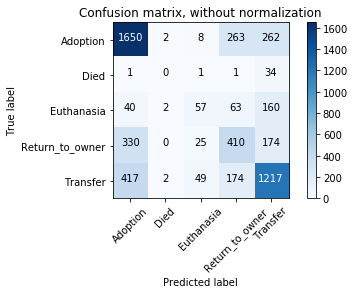

1.1355743897871882

In [16]:
# predict outcome based on test dogs
prediction = forest.predict(X_test)
prediction_proba = forest.predict_proba(X_test)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print(classification_report(y_test, prediction, target_names=le.classes_))

cnm = confusion_matrix(y_test, prediction)
plt.figure()
plot_confusion_matrix(cnm, classes=le.classes_,
                      title='Confusion matrix, without normalization')

plt.show()
plt.close()

log_loss(y_test, prediction_proba )


In [ ]:
print importances
#print np.sum(importances[:15])
print indices
ext_model_columns = np.hstack((model_columns, np.asarray(["SVD_" + str(x) for x in range(2)]))) 
#ext_model_columns = model_columns
feature_count = 14
plot_feature_importance(importances, indices, feature_count, ext_model_columns)
#print model_columns
#np.max(X_train[:,18:])

In [ ]:
#ext_model_columns[indices][:15]
X_train_res[1000,]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5, metric='jaccard')
knn.fit(X_train, y_train)

In [ ]:
prediction = knn.predict(X_test)

print(classification_report(y_test, prediction, target_names=le.classes_))

cnm = confusion_matrix(y_test, prediction)
plt.figure()
plot_confusion_matrix(cnm, classes=le.classes_,
                      title='Confusion matrix, without normalization')

plt.show()
plt.close()


In [17]:
lr = LogisticRegression()
#lr = LogisticRegression(penalty='l2', C=10**-1, random_state=0, multi_class='multinomial', solver='lbfgs')
#rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y_train, n_folds=5), scoring='accuracy')
#rfecv.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
X_train_best = X_train[:,[3, 12, 13,  1,  0]]
X_test_best = X_test[:,[3, 12, 13,  1,  0]]

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

       Adoption       0.66      0.85      0.74      2185
           Died       0.00      0.00      0.00        37
     Euthanasia       0.61      0.04      0.08       322
Return_to_owner       0.46      0.40      0.43       939
       Transfer       0.70      0.64      0.67      1859

    avg / total       0.63      0.64      0.62      5342

Confusion matrix, without normalization
[[1849    0    0  223  113]
 [   0    0    0    2   35]
 [  41    0   14   69  198]
 [ 404    0    1  378  156]
 [ 505    0    8  155 1191]]


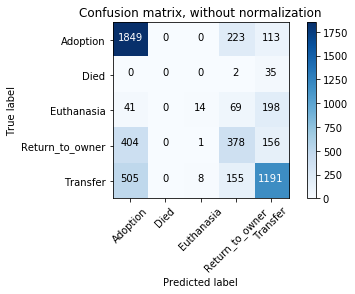

0.8623253657954606

In [18]:
prediction = lr.predict(X_test)
prediction_proba = lr.predict_proba(X_test)

print(classification_report(y_test, prediction, target_names=le.classes_))

cnm = confusion_matrix(y_test, prediction)
plt.figure()
plot_confusion_matrix(cnm, classes=le.classes_,
                      title='Confusion matrix, without normalization')

plt.show()
plt.close()

log_loss(y_test, prediction_proba )


# Train Ensemble of Logistic Regressors

In [ ]:
# taken from http://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html#sphx-glr-auto-examples-multioutput-plot-classifier-chain-yeast-py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

#yeast = fetch_mldata('yeast')
#_X = yeast['data']
#_Y = yeast['target'].transpose().toarray()

# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(X_train, y_train)
y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_similarity_score(y_test, y_pred_ovr)

# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(LogisticRegression(), order='random', random_state=i)
          for i in range(10)]

for chain in chains:
    chain.fit(X_train, y_train)
    
 
y_pred_chains = np.array([chain.predict(X_test) for chain in chains])

chain_jaccard_scores = [jaccard_similarity_score(y_test, y_pred_chain >= .5)
                        for y_pred_chain in y_pred_chains]

y_pred_ensemble = y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_similarity_score(y_test,
                                                  y_pred_ensemble >= .5)

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

print model_scores
x_pos = np.arange(len(model_names))


In [ ]:
# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()    


# Test a bunch of classifiers

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#h = .02  # step size in the mesh

names = ["Nearest Neighbors", 
         "Linear SVM", 
         #"RBF SVM", 
         #"Gaussian Process",
         "Decision Tree", "Random Forest",
         "Neural Net", "AdaBoost",
         "Naive Bayes"
         #, "QDA"]
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()
    #QuadraticDiscriminantAnalysis()]
]

scores=[]
# iterate over classifiers
for name, clf in zip(names, classifiers):    
    print "Doing %s" % (name)
    clf.fit(X_train_best, y_train)
    #score = clf.score(X_test, y_test)
    #scores.append(score)
    pred = clf.predict_proba(X_test_best)     
    scores.append(log_loss(y_test, pred))


In [ ]:
print scores
#classifiers[2].fit(X_train, y_train)
#predictions = classifiers[2].predict_proba(X_test)

In [ ]:
# oversample with SMOTE
from imblearn.over_sampling import SMOTE
ratios = {0:8584, 1:3000, 2:3000, 3:4000, 4:8000}
sm = SMOTE(random_state=0, ratio=ratios)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
# perform recursive feature elimination using stratified K fold cross validation
#lr = LogisticRegression(penalty='l2', C=10**-1, random_state=0, multi_class='multinomial', solver='lbfgs')
lr = LogisticRegression()
#rfecv = RFECV(estimator=lr, step=1, cv=StratifiedKFold(y_train, n_folds=5), scoring='accuracy')
#rfecv.fit(X_train, y_train)
lr.fit(X_train, y_train)

In [ ]:
#rfecv.grid_scores_
#model_columns[rfecv.ranking_ == 1]
# use all features for now

predictions = lr.predict(X_test)


In [ ]:
# try and optimise regularisation parameter C (inverse of lambda)

# return log loss for various regularisation C values over stratified folds
def score(clf, random_state = 0):
    kf = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y_train.shape[0], 5))
    score=[]
    for train, test in kf:
        X_train_tr, X_train_test = X_train[train, :], X_train[test, :]
        y_train_tr, y_train_test = y_train[train], y_train[test]        
        clf.fit(X_train_tr, y_train_tr)        
        pred[test,:] = clf.predict_proba(X_train_test)     
        score.append(log_loss(y_train_test, pred[test, :]))        
    print 'Log loss: %.3f' % (log_loss(y_train, pred))
    return score

Cs = np.logspace(-3,0,4)
#Cs = np.arange(-5, 5)
res = []
for c in Cs:
    res.append(np.mean(score(LogisticRegression(penalty='l1', C = c, random_state=0))))
    #res.append(np.mean(score(LogisticRegression(penalty='l2', C = c, random_state=0, 
     #                                           multi_class='multinomial', solver='lbfgs'))))
plt.semilogx(Cs, res,'-b');
#plt.plot(Cs, res, '-b')
plt.show()


In [ ]:
# run one-vs all logistic regression classifier
lr = LogisticRegression(penalty='l2', C=10**-1, random_state=0, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train_res, y_train_res)
#print X_test[0,:].reshape(-1,12)
predictions = lr.predict_proba(X_test)
print predictions
#lr.predict_proba(X_test[0,:].reshape(-1,12))
print lr.score(X_train, y_train)
print lr.score(X_test, y_test)




In [ ]:
# model beats the null model (whereby most frequent class is selected all the time).  This sort of model would
# be correct 41% of the time
# calculate accuracy score manually
result_array = np.hstack((y_test.reshape(-1,1), predictions.argmax(axis = 1).reshape(-1,1)))
print "Classifier accuracy: %.3f" % np.mean(np.where((result_array[:,0]==result_array[:,1]) == True, 1, 0))

#print recall_score(y_test, predictions)

# now i'd like to see which class was best predicted
# results in first column represent the target label classes
# find which class is worst predicted
class_distribution = []
for i in range(5):
    temp = result_array[result_array[:,0] == i,:]     
    class_distribution.append( np.mean(np.where((temp[:,0] == temp[:,1]), 1, 0)) )

# 
print "Classes: %s" % le.classes_
print "Class accuracy: %s" % class_distribution
# [0.409, 0.007, 0.06, 0.176, 0.348]

                   
print "Classifier log loss: %s" %  log_loss(y_test, predictions)

print "Recall %.4f" % recall_score(y_test, predictions.argmax(axis = 1), average='macro')
#print df.columns[9:]
#print le.classes_


# Imbarazz

In [ ]:
x = np.random.randn(1000)

fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(x, 50, normed=True)
fig.canvas.draw()
plt.show()

In [ ]:
print np.argmax(n)
#print n[30]
#print bins[29:31]
#print len(n)
#print len(bins)

from scipy import stats
#stats.norm.pdf(3, loc=0.0, scale=1.0)
#stats.norm.pdf(np.linspace(-1, 1), loc=0.0, scale=1.0)

#print 1- stats.norm.cdf(-1, loc=0, scale=1.)  - (1- stats.norm.cdf(1, loc=0, scale=1.) )
#print stats.norm.cdf(-1, loc=0, scale=1.)  
#- stats.norm.cdf(1, loc=0, scale=1.)

#print bins[1:]
#print bins[:-1]
print np.sum(n * (bins[1:] -  bins[:-1]))
print n * (bins[1:] -  bins[:-1])
print n
print bins

In [57]:
#minmax_scale = preprocessing.MinMaxScaler().fit(df[['Alcohol', 'Malic acid']])
#df_minmax = minmax_scale.transform(df[['Alcohol', 'Malic acid']])
from sklearn.preprocessing import MinMaxScaler 

data = [[0, 0, 0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 0, 1, 1, 1]]
scaler = MinMaxScaler()

minmax_scale = scaler.fit(data)
scaler.transform(data)

#df_minmax = minmax_scale.transform(df[['Alcohol', 'Malic acid']])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.]])